Get statistics about the dataset

In [166]:
import sparqlqueries as sq
import pandas as pd
import matplotlib.pyplot as plt
import paths as p
import json
from tqdm import tqdm

In [2]:
melart_annotations=json.load(open(p.MELART_ANNOTATIONS_PATH, 'r'))

In [3]:
artworks_qids=dict() # split -> list of qids (keys from the melart annotations)
for qid,melart_artwork in melart_annotations.items():
    split=melart_artwork['split']
    if split not in artworks_qids:
        artworks_qids[split]=[]
    artworks_qids[split].append(qid)
print([f"Split {split}: {len(qids)} artworks" for split,qids in artworks_qids.items()])

['Split test: 100 artworks', 'Split train: 1188 artworks', 'Split val: 328 artworks']


In [4]:
all_qids=[qid for split,qids in artworks_qids.items() for qid in qids]
print(f"Total: {len(all_qids)} artworks")

Total: 1616 artworks


In [101]:
mentions_qids=set()
mention_counts=dict()
for split,qids in artworks_qids.items():
    for qid in qids:
        for match_list in melart_annotations[qid]['visual_el_matches']+melart_annotations[qid]['contextual_el_matches']:
            for match in match_list:
                mentions_qids.add(match['qid'])
                if match['qid'] not in mention_counts:
                    mention_counts[match['qid']]=0
                mention_counts[match['qid']]+=1
total_mentions=sum(mention_counts.values())
print(f"Total: {len(mentions_qids)} entities in the mentions")
print(f"Total: {total_mentions} mentions")

Total: 1306 entities in the mentions
Total: 6585 mentions


Read jsonl of candidates

In [6]:
candidates=dict()
with open(p.CANDIDATES_FILE_PATH, 'r') as f:
    for line in f:
        candidate=json.loads(line)
        qid=candidate['qid']
        candidates[qid]=candidate
print(f"Read {len(candidates)} candidates")

Read 52769 candidates


In [198]:
def get_all_types(qid_list):
    """Get all types in the wikidata hierarchy for a list of qids, return a dataframe with columns 'qid', 'type' and 'type_label'"""
    types_dict=dict()
    # sparql_query="""
    # PREFIX wd: <http://www.wikidata.org/entity/>
    # PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    # PREFIX p: <http://www.wikidata.org/prop/>
    # prefix ps: <http://www.wikidata.org/prop/statement/>
    # PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    # SELECT DISTINCT ?qid ?type ?type_label WHERE{
    #     VALUES ?qid { %s }
    #     ?qid p:P31 ?statement0.
    #     ?statement0 (ps:P31/(wdt:P279*)) ?type.
    #     ?type rdfs:label ?type_label.
    #     FILTER ( STRSTARTS(STR(?type), STR(wd:)))
    #     FILTER ( LANG(?type_label) = "en" )
    # }
    # """ % ' '.join([f'wd:{qid}' for qid in qid_list])
    sparql_query="""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX p: <http://www.wikidata.org/prop/>
    prefix ps: <http://www.wikidata.org/prop/statement/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT DISTINCT ?qid ?type WHERE{
        VALUES ?qid { %s }
        ?qid p:P31 ?statement0.
        ?statement0 (ps:P31/(wdt:P279*)) ?type.
        FILTER ( STRSTARTS(STR(?type), STR(wd:)))
    }
    """ % ' '.join([f'wd:{qid}' for qid in qid_list])
    results=sq.sparql_pandas_query(sparql_query)
    results['qid']=results['qid'].apply(lambda x: x.split('/')[-1])
    results['type']=results['type'].apply(lambda x: x.split('/')[-1])
    return results
get_all_types(['Q159099','Q259261'])

,qid,type
0,Q159099,Q103940464
1,Q159099,Q106559804
2,Q159099,Q110224119
3,Q159099,Q110551885
4,Q159099,Q12898224
5,Q159099,Q154954
6,Q159099,Q159344
7,Q159099,Q164509
8,Q159099,Q215627
9,Q159099,Q24229398


In [199]:
# dataframe with qid and type
dfs=[]
batch_size=100
all_candidate_qids=list(candidates.keys())
batched_candidates=[{qid:candidates[qid] for qid in all_candidate_qids[i:i+batch_size]} for i in range(0, len(all_candidate_qids), batch_size)]
dataset_types=[candidates[qid]["types"].keys() for qid in all_candidate_qids]
dataset_types=list(set([item for sublist in dataset_types for item in sublist]))
for batch in tqdm(batched_candidates):
    types_entity_df=get_all_types(batch.keys())
    types_entity_df=types_entity_df[types_entity_df['type'].isin(dataset_types)]
    dfs.append(types_entity_df)
# for qid,data in tqdm(candidates.items()):
#     types_entity_df=get_all_types(qid)
#     dfs.append(types_entity_df)
    # types=candidates[qid]['types']
    # for typeqid,typelabel in types.items():
    #     df_data.append({'qid':qid, 'type':typeqid, 'type_label':typelabel})
df_types=pd.concat(dfs)
print("Total candidates type triples:", len(df_types))
df_types.head()

100%|██████████| 528/528 [00:49<00:00, 10.77it/s]

Total candidates type triples: 453575


,qid,type
9,Q103895463,Q13433827
10,Q103895463,Q151885
12,Q103895463,Q15621286
14,Q103895463,Q15989253
16,Q103895463,Q17537576


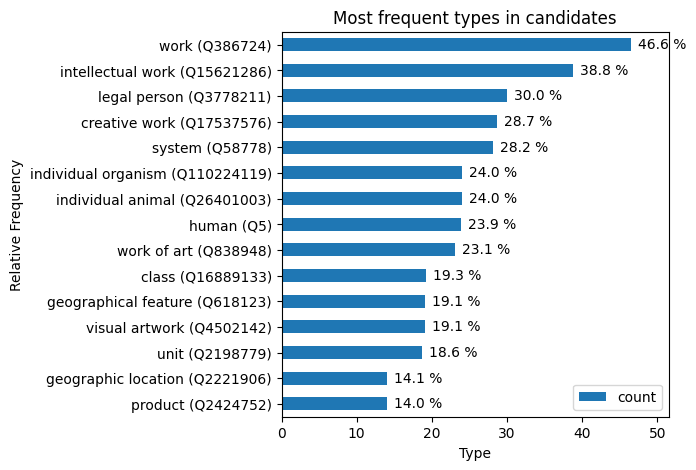

In [ ]:
# count of types
type_counts=df_types['type'].value_counts()
#normalize
type_counts=type_counts*100/len(candidates)
k=15
plot_df=pd.DataFrame(type_counts.head(k))
plot_labels=sq.sparql_all_lables(plot_df.index.to_list())
plot_df["type_label"]=plot_df.index.map(lambda x: f"{plot_labels[x][0]} ({x})")
plot_df=plot_df.set_index("type_label")
ax=plot_df.plot(kind='barh', title='Most frequent types in candidates', figsize=(5,5), xlabel='Type', ylabel='Relative Frequency', xlim=(0,max(type_counts.head(10))+5))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_candidates.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [203]:
df_types_mentions=df_types[df_types['qid'].isin(mentions_qids)]
print("Total mention types triples:", len(df_types_mentions))

Total mention types triples: 10064


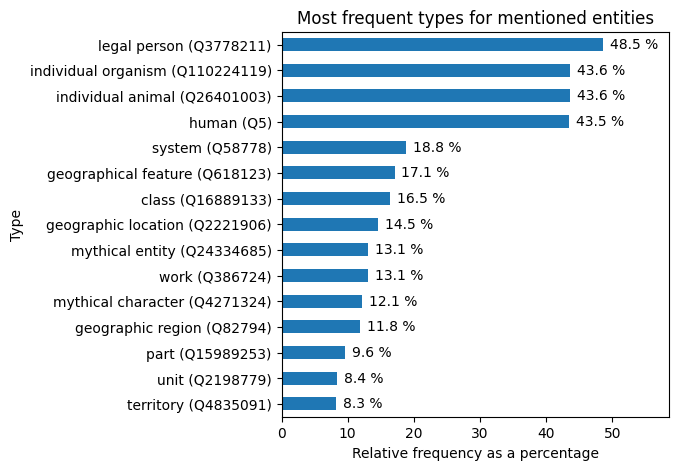

In [211]:
type_counts_mentions=df_types_mentions['type'].value_counts()
#normalize
type_counts_mentions=type_counts_mentions*100/len(mentions_qids)
k=15
plot_df=pd.DataFrame(type_counts_mentions.head(k))
plot_labels=sq.sparql_all_lables(plot_df.index.to_list())
plot_df["type_label"]=plot_df.index.map(lambda x: f"{plot_labels[x][0]} ({x})")
plot_df=plot_df.set_index("type_label")
ax=plot_df.plot(kind='barh', title='Most frequent types for mentioned entities', figsize=(5,5), ylabel='Type', xlabel='Relative frequency as a percentage', xlim=(0,max(type_counts_mentions.head(10))+10), legend=False)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/types_mentions.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [209]:
# legal persons (Q3778211) that are not humans (Q5)
legal_persons_df=df_types_mentions[df_types_mentions['type']=='Q3778211']
humans_df=df_types_mentions[df_types_mentions['type']=='Q5']
weird_legal_persons_df=legal_persons_df[~legal_persons_df['qid'].isin(humans_df['qid'])]
# distinct qids
weird_legal_persons_qids=set(weird_legal_persons_df['qid'])
weird_legal_persons_qids

{'Q10053',
 'Q12994',
 'Q1361268',
 'Q1492',
 'Q15077294',
 'Q151030',
 'Q159',
 'Q159605',
 'Q1602820',
 'Q160483',
 'Q16327702',
 'Q1640215',
 'Q164061',
 'Q181946',
 'Q191415',
 'Q1975176',
 'Q19862731',
 'Q20427',
 'Q2044',
 'Q212406',
 'Q2186',
 'Q220',
 'Q221507',
 'Q249679',
 'Q254829',
 'Q2634',
 'Q26421',
 'Q272101',
 'Q27613',
 'Q29',
 'Q290936',
 'Q30974',
 'Q329967',
 'Q34404',
 'Q3709831',
 'Q41',
 'Q42288',
 'Q426375',
 'Q43999',
 'Q4640',
 'Q4649',
 'Q48292',
 'Q486792',
 'Q49186',
 'Q499537',
 'Q539123',
 'Q5447471',
 'Q5776',
 'Q5836',
 'Q60',
 'Q604222',
 'Q6247',
 'Q6343',
 'Q64',
 'Q641',
 'Q690',
 'Q70899',
 'Q772',
 'Q772054',
 'Q80591',
 'Q819267',
 'Q822',
 'Q830183',
 'Q90',
 'Q928',
 'Q9920'}

[Text(5, 0, '42.9 %'),
 Text(5, 0, '4.2 %'),
 Text(5, 0, '3.6 %'),
 Text(5, 0, '2.8 %'),
 Text(5, 0, '2.3 %'),
 Text(5, 0, '2.1 %'),
 Text(5, 0, '1.6 %'),
 Text(5, 0, '1.5 %'),
 Text(5, 0, '1.4 %'),
 Text(5, 0, '1.3 %'),
 Text(5, 0, '1.2 %'),
 Text(5, 0, '1.1 %'),
 Text(5, 0, '1.0 %'),
 Text(5, 0, '1.0 %'),
 Text(5, 0, '1.0 %')]

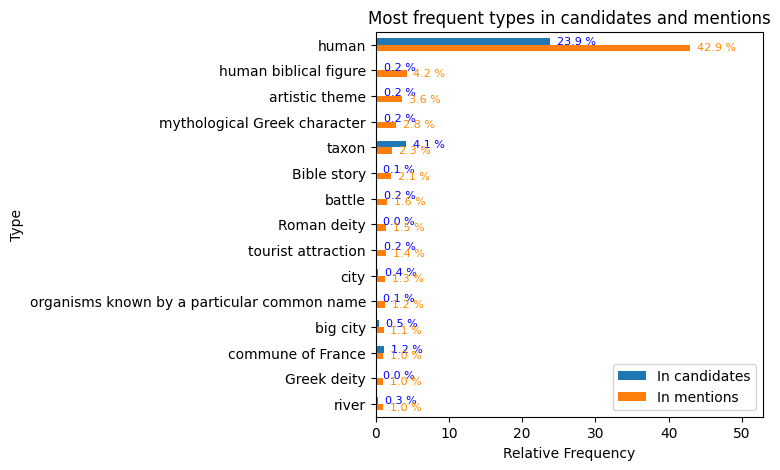

In [92]:
# combine the two type_count series into a dataframe
df_type_counts=pd.concat([type_counts, type_counts_mentions], axis=1)
df_type_counts.fillna(0, inplace=True)
df_type_counts.columns=['In candidates','In mentions']
df_type_counts.sort_values(by='In mentions', ascending=False, inplace=True)
ax=df_type_counts.head(15).plot(kind='barh', title='Most frequent types in candidates and mentions', figsize=(5,5), ylabel='Type', xlabel='Relative Frequency', xlim=(0,max(df_type_counts.head(15).max())+10), legend=True)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5, color='blue', fontsize=8)
ax.bar_label(ax.containers[1], fmt='%.1f %%', padding=5, color='darkorange', fontsize=8)

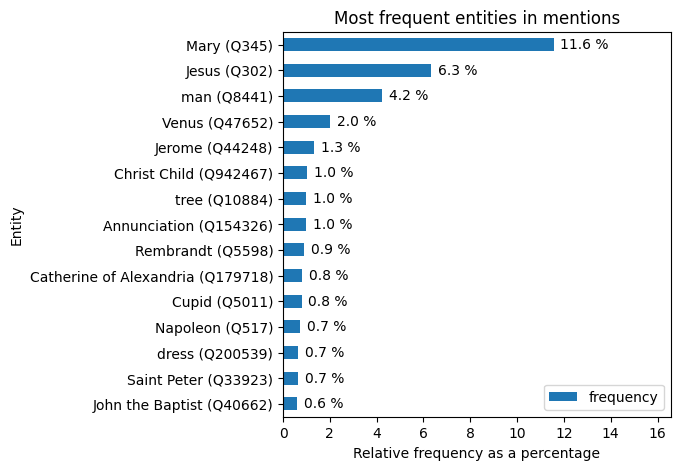

In [104]:
df_mention_counts=pd.DataFrame(mention_counts.items(), columns=['qid','count'])
mentions_labels=sq.sparql_all_lables(list(mentions_qids))
df_mention_counts['label']=df_mention_counts['qid'].map(lambda x: f"{mentions_labels[x][0]} ({x})")
df_mention_counts["frequency"]=df_mention_counts['count']*100/total_mentions
df_mention_counts.sort_values(by='count', ascending=False, inplace=True)
ax=df_mention_counts.head(15).plot(kind='barh', x='label', y='frequency', title='Most frequent entities in mentions', figsize=(5,5), xlabel='Relative frequency as a percentage', ylabel='Entity', xlim=(0,max(df_mention_counts.head(15)['frequency'])+5))
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/top_entities_mentions.pdf", format="pdf", bbox_inches='tight')

In [129]:
df_mention_counts["cum_frequency"]=df_mention_counts['frequency'].cumsum()
df_mention_counts["rank"]=range(1,len(df_mention_counts)+1)
df_mention_counts["rank_relative"]=df_mention_counts["rank"]*100/len(df_mention_counts)
df_mention_counts.head(10)

,qid,count,label,frequency,cum_frequency,rank,rank_relative,cum_count
0,Q345,761,Mary (Q345),11.556568,11.556568,1,0.076570,11.556568
2,Q302,416,Jesus (Q302),6.317388,17.873956,2,0.153139,17.873956
140,Q8441,279,man (Q8441),4.236902,22.110858,3,0.229709,22.110858
31,Q47652,132,Venus (Q47652),2.004556,24.115414,4,0.306279,24.115414
22,Q44248,86,Jerome (Q44248),1.305998,25.421412,5,0.382848,25.421412
1,Q942467,68,Christ Child (Q942467),1.032650,26.454062,6,0.459418,26.454062
188,Q10884,66,tree (Q10884),1.002278,27.456340,7,0.535988,27.456340
15,Q154326,65,Annunciation (Q154326),0.987092,28.443432,8,0.612557,28.443432
409,Q5598,58,Rembrandt (Q5598),0.880790,29.324222,9,0.689127,29.324222
46,Q179718,54,Catherine of Alexandria (Q179718),0.820046,30.144267,10,0.765697,30.144267


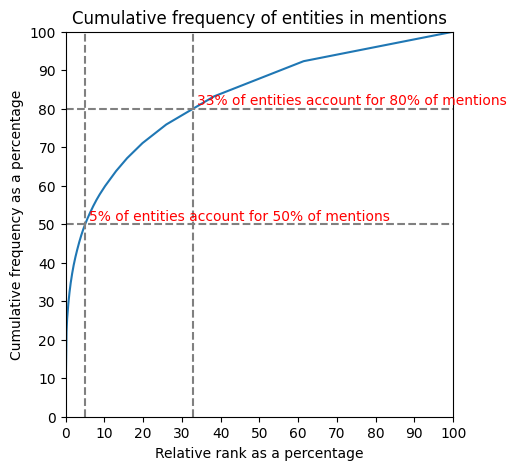

In [ ]:
ax=df_mention_counts.plot(x='rank_relative', y='cum_frequency', title='Cumulative frequency of entities in mentions', figsize=(5,5), xlabel='Relative rank as a percentage', ylabel='Cumulative frequency as a percentage', xticks=range(0,101,10), yticks=range(0,101,10), xlim=(0,100), ylim=(0,100), legend=False)
crossings=[50,80]
for crossing in crossings:
    y=crossing
    x=df_mention_counts[df_mention_counts["cum_frequency"]>=y].iloc[0]["rank_relative"]
    ax.axhline(y, color='grey', linestyle='--')
    ax.axvline(x, color='grey', linestyle='--')
    text=f"{round(x)}% of entities account for {y}% of mentions"
    ax.text(x+1, y+1, text, color='red')


Adjust the types according to the mentions count. For instance Mary is mentioned multiple types, so her types are "mentioned" multiple times.

In [144]:
#combine df_mention_counts and df_types
df_mention_types=df_mention_counts.merge(df_types, on='qid')
df_mention_types.head()

,qid,count,label,frequency,cum_frequency,rank,rank_relative,cum_count,type,type_label
0,Q345,761,Mary (Q345),11.556568,11.556568,1,0.076570,11.556568,Q20643955,human biblical figure
1,Q302,416,Jesus (Q302),6.317388,17.873956,2,0.153139,17.873956,Q20643955,human biblical figure
2,Q302,416,Jesus (Q302),6.317388,17.873956,2,0.153139,17.873956,Q5,human
3,Q47652,132,Venus (Q47652),2.004556,24.115414,4,0.306279,24.115414,Q11688446,Roman deity
4,Q47652,132,Venus (Q47652),2.004556,24.115414,4,0.306279,24.115414,Q1470705,fertility deity


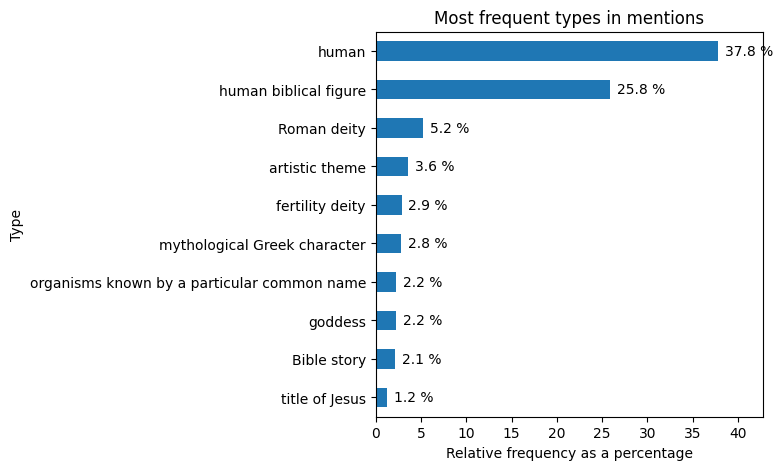

In [158]:
# group by type and sum the counts
df_mention_types_grouped=df_mention_types.groupby('type_label').sum(numeric_only=True).sort_values(by='count', ascending=False)
# keep only the count column
df_mention_types_grouped=df_mention_types_grouped[['count']]
# normalize
df_mention_types_grouped['count_norm']=df_mention_types_grouped['count']*100/total_mentions
k=10
ax=df_mention_types_grouped.head(k).plot.barh(y='count_norm', title='Most frequent types in mentions', figsize=(5,5), xlabel='Relative frequency as a percentage', ylabel='Type', xlim=(0,max(df_mention_types_grouped['count_norm'].head(k))+5), legend=False)
ax.invert_yaxis()
ax.bar_label(ax.containers[0], fmt='%.1f %%', padding=5)
plt.savefig("figures/top_types_mentions.pdf", format="pdf", bbox_inches='tight')

In [152]:
sum(df_mention_types_grouped['count'])

9311